In [4]:
import numpy as np
import json
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import multiprocessing
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import pickle
import os
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import mne_bids
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import io
from scipy import stats
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.plts.spectra import plot_spectrum
from neurodsp import sim
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum_welch
from neurodsp.plts import plot_time_series, plot_power_spectra
from fooof.bands import Bands

import statsmodels.api as sm
import statsmodels.formula.api as smf
# gradient boosted trees tend to do well on problems like this

BIDS_path = 'C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'

def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

def create_model():
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape=(40,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1,activation='linear'))

    #setup our optimizer and compile
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='mean_squared_error',
                 metrics=['mse'])
    return model

space_NN = [Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
              Integer(low=1, high=3, name='num_dense_layers'),
              Integer(low=1, high=10, prior='uniform', name='num_input_nodes'),
              Integer(low=1, high=10, name='num_dense_nodes'),
              Categorical(categories=['relu', 'tanh'], name='activation')
             ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space_NN)
def objective(**params):
    print(params)

    global learning_rate
    learning_rate=params["learning_rate"]
    global num_dense_layers
    num_dense_layers=params["num_dense_layers"]
    global num_input_nodes
    num_input_nodes=params["num_input_nodes"]
    global num_dense_nodes
    num_dense_nodes=params["num_dense_nodes"]
    global activation
    activation=params["activation"]



    model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=300, verbose=0)

    cv_res = cross_val_score(model, X_time, y_time, cv=2, n_jobs=1, scoring="r2")

    #kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    cv_res[np.where(cv_res < 0)[0]] = 0
    return -np.mean(cv_res)
    #return -cv_result['test-r2-mean'].iloc[-1]

faces = io.loadmat('C:\\Users\\ICN_admin\\Documents\\icn\\icn_plots\\faces.mat')
Vertices = io.loadmat('C:\\Users\\ICN_admin\\Documents\\icn\\icn_plots\\Vertices.mat')
grid = io.loadmat('C:\\Users\\ICN_admin\\Documents\\icn\\icn_plots\\grid.mat')['grid']
stn_surf = io.loadmat('C:\\Users\\ICN_admin\\Documents\\icn\\icn_plots\\STN_surf.mat')
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

def get_coord_all(l_choords_ecog_con):
    x_ = []; y_ = []
    for patient_idx in range(len(l_choords_ecog_con)):
        x_.append(np.array(l_choords_ecog_con[patient_idx])[0,:])
        y_.append(np.array(l_choords_ecog_con[patient_idx])[1,:])
    return np.concatenate(np.array(x_)), np.concatenate(np.array(y_))

In [5]:
df = pd.read_pickle("C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\NOISE_ap_spectrum.p")

In [6]:
df

,bids_id,hemisphere,channel,mni_x,mni_y,mni_z,R_squared_con,R_squared_ips,dist,loc,sub,beta_peak
0,000,RIGHT,ECOG_RIGHT_0,37.318174,-48.610127,61.797655,0.816271,0.594602,23.714756,ECOG,000,3.004269
1,000,RIGHT,ECOG_RIGHT_1,40.159894,-37.315930,64.311716,0.819618,0.613861,12.718657,ECOG,000,4.356077
2,000,RIGHT,ECOG_RIGHT_2,40.943036,-27.217785,64.095184,0.793244,0.592786,4.524949,ECOG,000,3.654367
3,000,RIGHT,ECOG_RIGHT_3,39.783955,-17.005231,63.866181,0.783414,0.628678,8.466679,ECOG,000,3.849308
4,000,RIGHT,ECOG_RIGHT_4,39.688136,-5.528025,61.682543,0.790183,0.537785,19.792789,ECOG,000,2.562056
...,...,...,...,...,...,...,...,...,...,...,...,...
266,014,RIGHT,ECOG_RIGHT_5,43.420959,6.349383,48.335197,0.258164,0.239244,35.628620,ECOG,014,2.542724
267,014,RIGHT,STN_RIGHT_0,14.812955,-14.134391,-3.867494,0.237795,0.276684,3.085589,STN,014,0.000000
268,014,RIGHT,STN_RIGHT_1,15.164177,-13.053698,-1.966183,0.268934,0.301079,4.695180,STN,014,0.089447
269,014,RIGHT,STN_RIGHT_2,15.509334,-11.937049,-0.077220,0.302298,0.321625,6.656342,STN,014,0.110837


In [7]:
subject_id

['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

### ECOG 

In [50]:
df_6A = pd.DataFrame()
for sub in subject_id:
    for hem in ["RIGHT", "LEFT"]:
        df_here = df[df["loc"].str.contains("ECOG")]
        df_here = df_here[df_here["bids_id"].str.contains(sub)]
        df_here = df_here[df_here["hemisphere"].str.contains(hem)]
        if df_here.shape[0] == 0:
            continue
        min_dist = df_here.dist.argmin()
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":"ips",
            "x":df_here.loc[min_dist]["mni_x"], 
            "y":df_here.loc[min_dist]["mni_y"], 
            "mod":"closest",
            "sub":sub, 
            "loc":"ECOG"
        }, ignore_index=True)
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":"con",
            "x":df_here.loc[min_dist]["mni_x"], 
            "y":df_here.loc[min_dist]["mni_y"], 
            "mod":"closest",
            "sub":sub,
            "loc":"ECOG"
        }, ignore_index=True)
            
        for lat in ["con", "ips"]:
            lat_ = "R_squared_"+lat
            max_per = df_here[lat_].argmax()
            df_6A = df_6A.append({
                "hem":hem, 
                "lat":lat,
                "x":df_here.loc[max_per]["mni_x"], 
                "y":df_here.loc[max_per]["mni_y"], 
                "mod":"best",
                "sub":sub,
                "loc":"ECOG"
            }, ignore_index=True)
                

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  if __name__ == '__main__':
C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [51]:
choord_closest_ECOG_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "ECOG")][["x", "y"]])
choord_closest_ECOG_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "ECOG")][["x", "y"]])
choord_best_ECOG_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "best")& (df_6A["loc"] == "ECOG")][["x", "y"]])
choord_best_ECOG_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "best")& (df_6A["loc"] == "ECOG")][["x", "y"]])

In [52]:
for sub in subject_id:
    for hem in ["RIGHT", "LEFT"]:
        df_here = df[df["loc"].str.contains("STN")]
        df_here = df_here[df_here["bids_id"].str.contains(sub)]
        df_here = df_here[df_here["hemisphere"].str.contains(hem)].reset_index()
        if df_here.shape[0] == 0:
            continue
        min_dist = df_here.dist.argmin()
        
        if min_dist == 0:
            x_ = (np.array(df_here[["mni_x", "mni_y"]])[1,0] + np.array(df_here[["mni_x", "mni_y"]])[0,0])/2
            y_ = (np.array(df_here[["mni_x", "mni_y"]])[1,1] + np.array(df_here[["mni_x", "mni_y"]])[0,1])/2
        if min_dist == 1:
            x_ = (np.array(df_here[["mni_x", "mni_y"]])[1,0] + np.array(df_here[["mni_x", "mni_y"]])[2,0])/2
            y_ = (np.array(df_here[["mni_x", "mni_y"]])[1,1] + np.array(df_here[["mni_x", "mni_y"]])[2,1])/2
        if min_dist == 2:
            try:
                x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[3,0])/2
                y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[3,1])/2
            except:
                    x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[1,0])/2
                    y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[1,1])/2

        if min_dist == 3:
            try:
                x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[3,0])/2
                y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[3,1])/2
            except:
                x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[1,0])/2
                y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[1,1])/2

        
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":lat,
            "x":x_, 
            "y":y_, 
            "mod":"closest",
            "sub":sub,
            "loc":"STN"
        }, ignore_index=True)
        df_6A = df_6A.append({
            "hem":hem, 
            "lat":"con",
            "x":x_, 
            "y":y_, 
            "mod":"closest",
            "sub":sub,
            "loc":"STN"
        }, ignore_index=True)
            
        for lat in ["con", "ips"]:
            lat_ = "R_squared_"+lat
            max_per = df_here[lat_].argmax()
            
            if max_per == 0:
                x_ = (np.array(df_here[["mni_x", "mni_y"]])[1,0] + np.array(df_here[["mni_x", "mni_y"]])[0,0])/2
                y_ = (np.array(df_here[["mni_x", "mni_y"]])[1,1] + np.array(df_here[["mni_x", "mni_y"]])[0,1])/2
            if max_per == 1:
                x_ = (np.array(df_here[["mni_x", "mni_y"]])[1,0] + np.array(df_here[["mni_x", "mni_y"]])[2,0])/2
                y_ = (np.array(df_here[["mni_x", "mni_y"]])[1,1] + np.array(df_here[["mni_x", "mni_y"]])[2,1])/2
            if max_per == 2:
                try:
                    x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[3,0])/2
                    y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[3,1])/2
                except:
                    x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[1,0])/2
                    y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[1,1])/2

            if max_per == 3:
                try:
                    x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[3,0])/2
                    y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[3,1])/2
                except:
                    x_ = (np.array(df_here[["mni_x", "mni_y"]])[2,0] + np.array(df_here[["mni_x", "mni_y"]])[1,0])/2
                    y_ = (np.array(df_here[["mni_x", "mni_y"]])[2,1] + np.array(df_here[["mni_x", "mni_y"]])[1,1])/2
            
            df_6A = df_6A.append({
                "hem":hem, 
                "lat":lat,
                "x":x_, 
                "y":y_, 
                "mod":"best",
                "sub":sub,
                "loc":"STN"
            }, ignore_index=True)
                

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  
C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [53]:
choord_closest_STN_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "STN")][["x", "y"]])
choord_closest_STN_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "closest")& (df_6A["loc"] == "STN")][["x", "y"]])
choord_best_STN_CON = np.array(df_6A[(df_6A["lat"] == "con") & (df_6A["mod"] == "best")& (df_6A["loc"] == "STN")][["x", "y"]])
choord_best_STN_IPS = np.array(df_6A[(df_6A["lat"] == "ips") & (df_6A["mod"] == "best")& (df_6A["loc"] == "STN")][["x", "y"]])

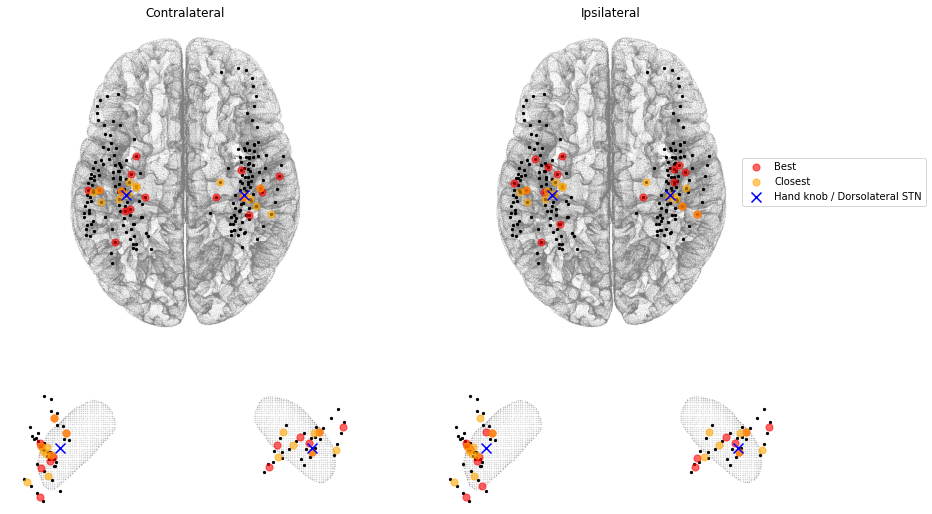

In [54]:
height_STN = 1
height_ECOG = 2.5*height_STN
fig, axes = plt.subplots(2,2, facecolor=(1,1,1), gridspec_kw={'height_ratios': [height_ECOG, height_STN]}, \
                         figsize=(14,9))#, dpi=600)
axes[0,0].scatter(x_ecog, y_ecog, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "ECOG"][["mni_x", "mni_y"]])[:,0]
y_ = np.array(df[df["loc"] == "ECOG"][["mni_x", "mni_y"]])[:,1]
axes[0,0].scatter(x_, y_, s=5, c='black')
axes[0,0].scatter(choord_best_ECOG_CON[:,0], choord_best_ECOG_CON[:,1], c='red', s=50, alpha=0.6)
axes[0,0].scatter(choord_closest_ECOG_CON[:,0], choord_closest_ECOG_CON[:,1], c='orange', s=50, alpha=0.6)
axes[0,0].scatter(37, -25, c='blue', s=100, marker='x')
axes[0,0].scatter(-37, -25, c='blue', s=100, marker='x')
axes[0,0].axes.set_aspect('equal', anchor='C')
axes[0,0].axes.set_title('Contralateral')

axes[1,0].axes.set_aspect('equal', anchor='C')

axes[1,0].scatter(x_stn, y_stn, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "STN"][["mni_x", "mni_y"]])[:,0]
y_ = np.array(df[df["loc"] == "STN"][["mni_x", "mni_y"]])[:,1]
axes[1,0].scatter(x_, y_, s=5, c='black')
axes[1,0].scatter(choord_best_STN_CON[:,0], choord_best_STN_CON[:,1], c='red', s=50, alpha=0.6)
axes[1,0].scatter(choord_closest_STN_CON[:,0], choord_closest_STN_CON[:,1], c='orange', s=50, alpha=0.6)
axes[1,0].scatter(12.58, -13.41, c='blue', s=100, marker='x')
axes[1,0].scatter(-12.58, -13.41, c='blue', s=100, marker='x')

axes[0,1].scatter(x_ecog, y_ecog, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "ECOG"][["mni_x", "mni_y"]])[:,0]
y_ = np.array(df[df["loc"] == "ECOG"][["mni_x", "mni_y"]])[:,1]
axes[0,1].scatter(x_, y_, s=5, c='black')
axes[0,1].scatter(choord_best_ECOG_IPS[:,0], choord_best_ECOG_IPS[:,1], c='red', s=50, alpha=0.6, label='Best')
axes[0,1].scatter(choord_closest_ECOG_IPS[:,0], choord_closest_ECOG_IPS[:,1], c='orange', s=50, alpha=0.6, label='Closest')
axes[0,1].scatter(37, -25, c='blue', s=100, marker='x', label='Hand knob / Dorsolateral STN')
axes[0,1].scatter(-37, -25, c='blue', s=100, marker='x')
axes[0,1].axes.set_aspect('equal', anchor='C')
axes[0,1].axes.set_title('Ipsilateral')

axes[1,1].axes.set_aspect('equal', anchor='C')

axes[1,1].scatter(x_stn, y_stn, c="gray", s=0.001)
x_ = np.array(df[df["loc"] == "STN"][["mni_x", "mni_y"]])[:,0]
y_ = np.array(df[df["loc"] == "STN"][["mni_x", "mni_y"]])[:,1]
axes[1,1].scatter(x_, y_, s=5, c='black')
axes[1,1].scatter(choord_best_STN_IPS[:,0], choord_best_STN_IPS[:,1], c='red', s=50, alpha=0.6)
axes[1,1].scatter(choord_closest_STN_IPS[:,0], choord_closest_STN_IPS[:,1], c='orange', s=50, alpha=0.6)
axes[1,1].scatter(12.58, -13.41, c='blue', s=100, marker='x')
axes[1,1].scatter(-12.58, -13.41, c='blue', s=100, marker='x')

axes[0,0].set_axis_off()
axes[0,1].set_axis_off()
axes[1,0].set_axis_off()
axes[1,1].set_axis_off()

axes[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [55]:
def get_num(arr_closest, arr_best):
    cnt = 0
    for hem_cnt in range(arr_closest.shape[0]):

        if np.array_equal(arr_best[hem_cnt,:], arr_closest[hem_cnt,:]):
            cnt +=1
    a = (arr_closest - arr_best)
    a_ = np.sqrt(a[:,0]**2+a[:,1]**2)
    print(str(a_.mean())+ " "+ str(a_.std()))
    print(cnt)
    

In [60]:
choord_closest_ECOG_CON.shape

(16, 2)

In [56]:
get_num(choord_closest_ECOG_CON, choord_best_ECOG_CON)

10.003386683676986 8.18425296483064
4


In [57]:
get_num(choord_closest_ECOG_IPS, choord_best_ECOG_IPS)

12.006640332329408 8.396247960546399
3


In [61]:
choord_closest_STN_CON.shape

(16, 2)

In [62]:
get_num(choord_closest_STN_CON, choord_best_STN_CON)

0.879932250203296 0.7457457044202919
6


In [63]:
get_num(choord_closest_STN_IPS, choord_best_STN_IPS)

1.1366574157239286 0.8103667463125765
4
